In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# **Introduction**
According to Unicef (2021):
* Globally, a child dies of pneumonia every 39 seconds.
* Pneumonia claims the lives of over 800,000 children under five every year, or around 2,200 every day. This includes over 153,000 newborns.
* Pneumonia is a leading cause of morbidity and mortality in children younger than the age of 5 years, killing more children than HIV/AIDS, malaria, and measles combined.

Chest X-rays are primarily used for the diagnosis of this disease. However, even for a trained radiologist, it is a challenging task to examine chest X-rays. 
To solve this, deep learning (DL), a branch of machine learning (ML), inspired by the make-up of the human brain, are developed to detect hidden features in images which are not apparent or cannot be detected even by medical experts. With AI system aiding medical experts in expediting the diagnosis, earlier treatment can be prescribed, resulting in improved clinical outcomes.

In [2]:
import random
random.seed(123)

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2
import datetime
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from PIL import Image
import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc,roc_curve,roc_auc_score

In [3]:
#set Adam optimizer with a learning rate of 1e-4 or 0.0001
optimizer = keras.optimizers.Adam(learning_rate = 1e-5)

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10),
                 ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]

# Data Visualization

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children's Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients' routine clinical care.

In [4]:
#define path to the data directory
base_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_dir = base_dir + 'train/'
test_dir = base_dir + 'test/'
val_dir = base_dir + 'val/'

#train dataset
train_normal = train_dir + 'NORMAL/'
train_pneu = train_dir + 'PNEUMONIA/'

#test dataset
test_normal = test_dir + 'NORMAL/'
test_pneu = test_dir + 'PNEUMONIA/'

#validation dataset
val_normal = val_dir + 'NORMAL/'
val_pneu = val_dir + 'PNEUMONIA/'

In [5]:
#check for number of images in each dataset
#normal condition
print('Train Normal:', len(os.listdir(train_normal)))
print('Test Normal:', len(os.listdir(test_normal)))
print('Val Normal:', len(os.listdir(val_normal)))
print('\n')

#pneumonia condition
print('Train Pneumonia:', len(os.listdir(train_pneu)))
print('Test Pneumonia:', len(os.listdir(test_pneu)))
print('Val Pneumonia:', len(os.listdir(val_pneu)))

Train Normal: 1341
Test Normal: 234
Val Normal: 8


Train Pneumonia: 3875
Test Pneumonia: 390
Val Pneumonia: 8


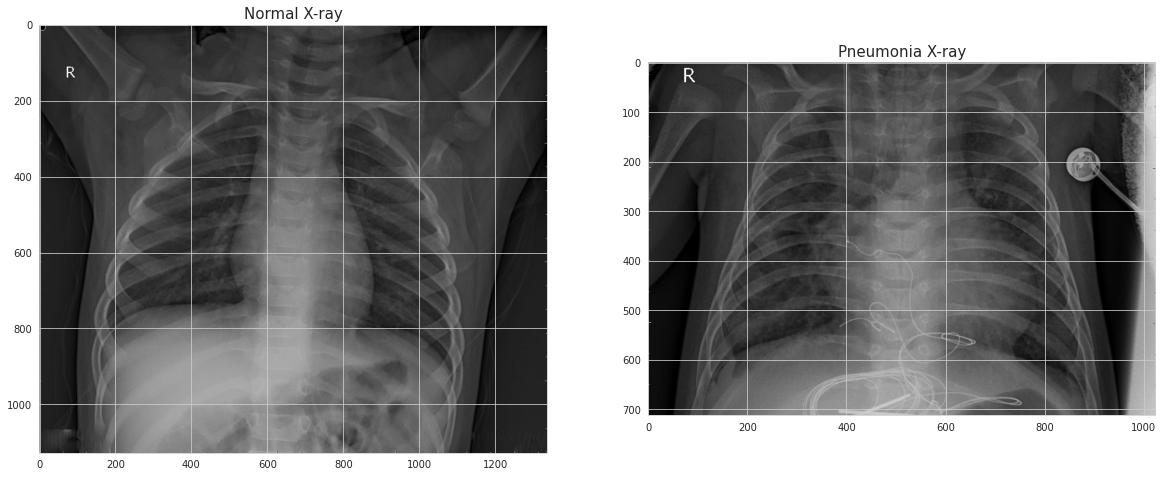

In [6]:
from PIL import Image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

normal = Image.open(train_normal + os.listdir(train_normal)[0])
pneu = Image.open(train_pneu + os.listdir(train_pneu)[0])

fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Normal X-ray', fontsize = 15)
plt.imshow(normal, cmap = 'gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pneumonia X-ray', fontsize = 15)
plt.imshow(pneu, cmap = 'gray')

In [7]:
#save
plt.savefig('X-ray.png')

<Figure size 432x288 with 0 Axes>

The presence of white hazy patches known as "ground-glass opacity" indicates pneumonia in infected patient which is absent in healthy persons.

There are 2 sub-categories for Pneumonia: Bacterial and Viral pathogens, which are the two leading causes of pneumonia, but require very different forms of management. Bacterial pneumonia requires urgent referral for immediate antibiotic treatment, while viral pneumonia is treated with supportive care (Kermany, 2018). For this project, we will only look at Normal vs. Pneumonia as a binary classification problem and will further investigate Normal vs. Viral vs. Bacterial as a multi-class classification problem in the future.

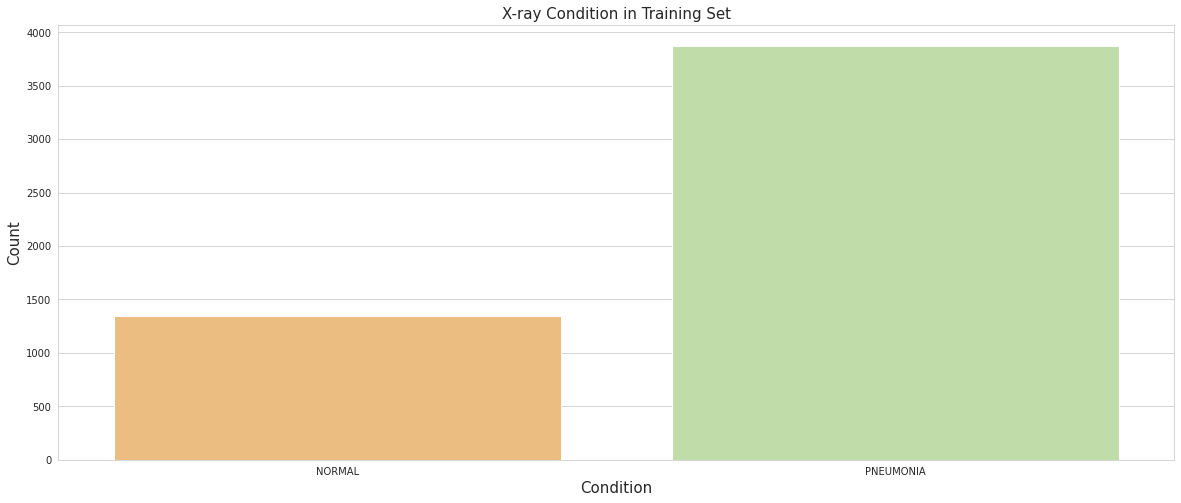

In [8]:
#visualize each class
import seaborn as sns

plt.figure(figsize = (20, 8))
sns.barplot(x = ['NORMAL', 'PNEUMONIA'], 
            y = [len(os.listdir(train_normal)), len(os.listdir(train_pneu))],
            palette = 'Spectral')
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('X-ray Condition in Training Set', fontsize = 15);

Right away we can see that there is a class imbalance problem. There are more Pneumonia cases than Normal cases. I see this as an advantage as the model will tend to do better on the major class (Pneumonia) than on the minor class (Normal). The FP (Normal classified as Pneumonia) will be high, but this is significantly less costly than FN (Pneumonia classified as Normal), which can be a fatal mistake. Hence, we will not correct this class imbalance.

# Data Augmentation
To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc of each training instances (Geron, 2019, p. 465). To achieve this, .ImageDataGenerator() is used. The ImageDataGenerator will automatically label all the data inside Pneumonia folder as Pneumonia and Normal for Normal folder. In this way data is easily ready to be passed to the neural network.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array

#augment train and validation dataset to prevent overfitting by increasing number of images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   
                                   #randomly rotate images
                                   rotation_range = 40,
                                   
                                   #randomly shear angles
                                   shear_range = 0.2,
                                   
                                   #randomly zoom images
                                   zoom_range = 0.2,
                                   
                                   #randomly shift images
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   
                                   # randomly flip images
                                   horizontal_flip = True,
                                   
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 40,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

#rescale test dataset without augmentation since real world data is not augmented
test_datagen = ImageDataGenerator(rescale = 1./255)

I see that validation set only has 16 images, which is significantly smaller than train set of 5216 images. I made the decision to not use this set to validate training but use test set instead.

.flow_from_directory is used to get all of the augmented data into the directory. The function passes the folder which has train data to the object train_generator and similarly passes the folder which has test data to the object test_generator, and val data to the object val_generator.

In [10]:
#get all the data in the directory with specified batch sizes and image dimensions
train_generator = train_datagen.flow_from_directory(
        #target directory
        train_dir,
    
        #resize to 150x150
        target_size = (150, 150),
    
        #size batches of data
        batch_size = 32,
    
        #since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  shuffle = False)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Since I use loss = 'binary_crossentropy', I need to set class mode = 'binary'.

I've found that it is important to set shuffle = False for test set or else when making prediction later, function .evaluate() and function .predict_classes() will yield different accuracy score. When set to False, data is sorted in alphanumeric order while default is set to True, which shuffles the data.

In [11]:
#code from https://www.kaggle.com/rafetcan/pneumonia-normal-cnn-model

import cv2
def picture_separation(folder):
    
    '''divide the mixed pictures into NORMAL and PNEUMONIA & add labels to these'''
    
    X = []
    y = []
    image_list = []

    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            if foldername == "NORMAL":
                label = 0
            elif foldername == "PNEUMONIA":
                label = 1
            else:
                label = 2
                
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
                

                if img_file is not None:
                    img = cv2.resize(img_file,(64,64))
                    img_arr = img_to_array(img) / 255
                    X.append(img_arr)
                    y.append(label)
                    image_list.append(foldername + '/' + image_filename)
                                        
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y, image_list

In [12]:
#get train dataset
X_train, y_train, img_train = picture_separation(train_dir)

train_df = pd.DataFrame(img_train, columns = ["images"])
train_df["target"] = y_train

#preview
train_df.head()

,images,target
0,PNEUMONIA/person1180_virus_2010.jpeg,1
1,PNEUMONIA/person1230_virus_2081.jpeg,1
2,PNEUMONIA/person1513_virus_2632.jpeg,1
3,PNEUMONIA/person124_virus_238.jpeg,1
4,PNEUMONIA/person746_virus_1369.jpeg,1


In [13]:
#get validation dataset
X_val, y_val, img_val = picture_separation(val_dir)

val_df = pd.DataFrame(img_val, columns = ["images"])
val_df["target"] = y_val

#preview
val_df.head()

,images,target
0,PNEUMONIA/person1947_bacteria_4876.jpeg,1
1,PNEUMONIA/person1946_bacteria_4875.jpeg,1
2,PNEUMONIA/person1952_bacteria_4883.jpeg,1
3,PNEUMONIA/person1954_bacteria_4886.jpeg,1
4,PNEUMONIA/person1951_bacteria_4882.jpeg,1


In [14]:
#get test dataset
X_test, y_test, img_test = picture_separation(test_dir)

test_df = pd.DataFrame(img_test, columns = ["images"])
test_df["target"] = y_test

#preview
test_df.head()

,images,target
0,PNEUMONIA/person1676_virus_2892.jpeg,1
1,PNEUMONIA/person1650_virus_2852.jpeg,1
2,PNEUMONIA/person22_virus_55.jpeg,1
3,PNEUMONIA/person122_bacteria_582.jpeg,1
4,PNEUMONIA/person85_bacteria_417.jpeg,1


In [15]:
#merge to get full dataset
full_data = pd.concat([train_df, test_df, val_df], axis = 0, ignore_index = True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5856 non-null   object
 1   target  5856 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.6+ KB


In [16]:
#save
full_data.to_csv('full_data')

The data need to be reshaped from (64, 64), a 64x64 matrix, to (4096,), a 4096-element vector, which is required for learning.

In [17]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\n')

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\n')

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (5216, 64, 64, 1)
y_train shape: (5216,)


X_test shape: (624, 64, 64, 1)
y_test shape: (624,)


X_val shape: (16, 64, 64, 1)
y_val shape: (16,)


In [18]:
#we need to reshape them from (64, 64), a 64x64 matrix, to (4096,), a 4096-element vector
X_train = X_train.reshape(5216, 64*64).astype('float32')
X_test = X_test.reshape(624, 64*64).astype('float32')
X_val = X_val.reshape(16, 64*64).astype('float32')

In [19]:
#recheck
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_val shape:', X_val.shape)

X_train shape: (5216, 4096)
X_test shape: (624, 4096)
X_val shape: (16, 4096)


# Multilayer Perceptron Model (MLP)

* I start with initializing the model by specifying that the model is a Sequential model. Sequential model is the simplest Keras model for neural networks that are composed with just one single stack of layers connected sequentially (Geron, 2019, p.299)
* The input layer needs to have input_shape = (4096,) specified.
* Three Dense hidden layers with 32, 64, and 128 neurons, are added after that. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). I also add activation = 'relu' (Rectified Linear Unit) to each layers so that all the negative values will not get passed to the next layer.
* One output layer with activation = 'sigmoid' is added last. Since this is a binary classification problem, only one single output neuron is needed.

In [20]:
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

#initiate
mlp_model = models.Sequential()

#mulilayers with relu activation
mlp_model.add(Dense(32, activation = 'relu', input_shape = (4096,)))
mlp_model.add(Dense(32, activation = 'relu'))
mlp_model.add(Dense(64, activation = 'relu'))
mlp_model.add(Dense(128, activation = 'relu'))

#one layer with sigmoid activation 
mlp_model.add(Dense(1, activation = 'sigmoid'))

Next, I compile the model and specify the loss function, the optimizer, and the metrics to use. Since the problem is binary classification and I use 'sigmoid' as activation function in the output layer, I have to use loss = 'binary_crossentropy' here.

In [21]:
from keras import optimizers

mlp_model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [22]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                131104    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 142,721
Trainable params: 142,721
Non-trainable params: 0
_________________________________________________________________


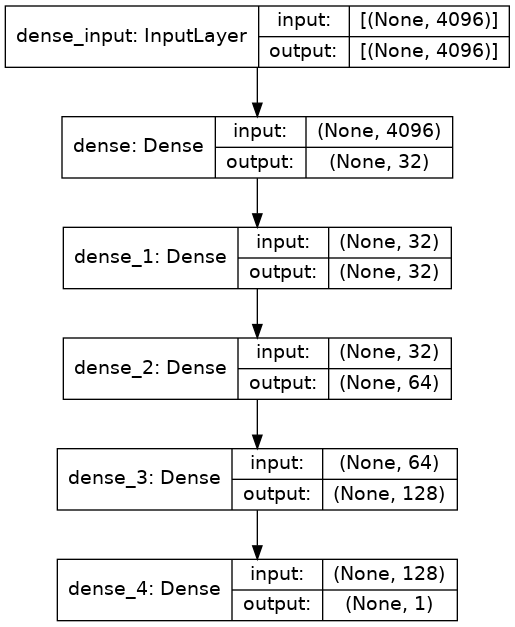

In [23]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(mlp_model, to_file = 'mlp_model_plot.png', show_shapes = True, show_layer_names = True)

There are a lot of parameters for each Dense layer. For example, the first hidden layer has 32 x 4096 connection weights plus 32 bias terms, adds up to 131104 parameters. Since we do not have a large dataset, we run the risk of overfitting our model because of this.

Using test set as validation data (X_test and y_test), I fit the model with X_train and y_train.

In [24]:
import datetime
start = datetime.datetime.now()

#fit
mlp_history = mlp_model.fit(X_train, y_train,
                            epochs = 30,
                            batch_size = 32,
                            validation_data = (X_test, y_test),
                            validation_steps = 624 // 32)

Epoch 1/30
163/163 [==============================] - 2s 6ms/step - loss: 0.4975 - acc: 0.7594 - val_loss: 0.4091 - val_acc: 0.7944
Epoch 2/30
163/163 [==============================] - 0s 3ms/step - loss: 0.2167 - acc: 0.9177 - val_loss: 0.4935 - val_acc: 0.7681
Epoch 3/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1679 - acc: 0.9346 - val_loss: 0.5992 - val_acc: 0.7599
Epoch 4/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1440 - acc: 0.9461 - val_loss: 0.6312 - val_acc: 0.7566
Epoch 5/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1289 - acc: 0.9518 - val_loss: 0.5740 - val_acc: 0.7763
Epoch 6/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1253 - acc: 0.9514 - val_loss: 0.3988 - val_acc: 0.8158
Epoch 7/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1300 - acc: 0.9523 - val_loss: 0.7363 - val_acc: 0.7533
Epoch 8/30
163/163 [==============================] - 0s 3ms/step - loss: 0.

In [25]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:00:15.495001


In [26]:
#save model
mlp_model.save('mlp_model.h5')

### Model Evaluation

Keras measures the loss and accuracy at the end of every epoch. All training acc and val_acc can be found with .history. I will use this information to plot accuracy and loss of the model.

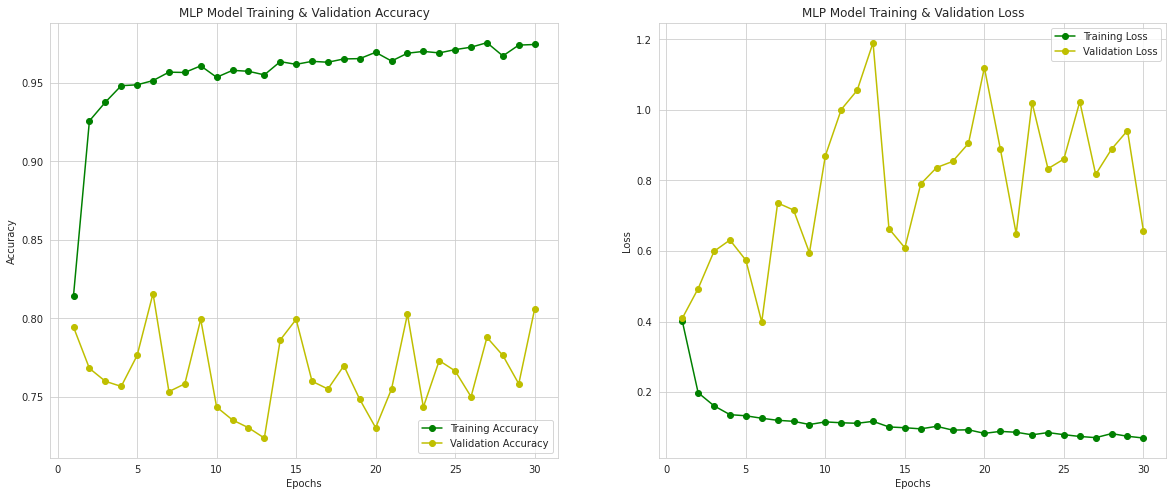

In [27]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

mlp_train_acc = mlp_history.history['acc']
mlp_train_loss = mlp_history.history['loss']
mlp_val_acc = mlp_history.history['val_acc']
mlp_val_loss = mlp_history.history['val_loss']

epochs = range(1, len(mlp_train_acc) + 1)

ax[0].plot(epochs , mlp_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , mlp_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('MLP Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , mlp_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , mlp_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('MLP Model Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [28]:
#save
plt.savefig('mlp_model.png')

<Figure size 432x288 with 0 Axes>

.evaluate() is for evaluating our trained model

In [29]:
print('Train loss & accuracy:' , mlp_model.evaluate(X_train, y_train))
print('\n')
print('Test loss & accuracy:' , mlp_model.evaluate(X_test, y_test))

163/163 [==============================] - 0s 2ms/step - loss: 0.0872 - acc: 0.9676
Train loss & accuracy: [0.08716818690299988, 0.9675996899604797]


20/20 [==============================] - 0s 1ms/step - loss: 0.7085 - acc: 0.7949
Test loss & accuracy: [0.7084700465202332, 0.7948718070983887]


Train and test accuracy are quite different. The model is overfit, as expected due to large amount of parameters trained on small dataset. The model is overtrained and learned well but it did not generalize well with test data. Training curve and Validation curve do not match each other. Validation Accuracy decreases and Validation Loss increases as the training goes on, which is a sign of a bad model.

.predict() is for predicting target value, predicted from our test data

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

#make prediction
yhat_test = mlp_model.predict_classes(X_test)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

[[116 118]
 [ 10 380]]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
#code from https://www.kaggle.com/basel99/chest-x-ray-images-cnn-handling-overfitting

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(b = None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

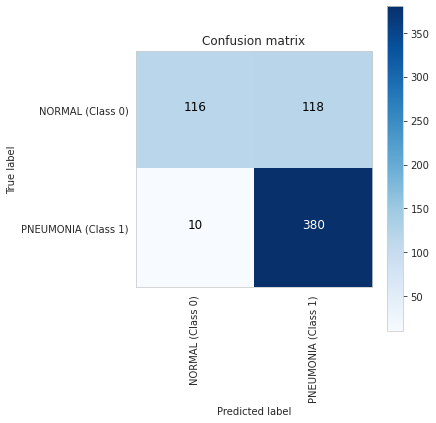

In [32]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [33]:
#save
plt.savefig('mlp_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [34]:
from sklearn.metrics import classification_report

print('Model: Multilayer Perceptron', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: Multilayer Perceptron 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.50      0.64       234
PNEUMONIA (Class 1)       0.76      0.97      0.86       390

           accuracy                           0.79       624
          macro avg       0.84      0.74      0.75       624
       weighted avg       0.82      0.79      0.78       624



The model perform better on class Pneumonia than class Normal, as reflected through F1-score. 
Although some Normal are classified as Pneumonia (FP), the MLP Model performs not so bad in classifying Pneumonia as Pneumonia. 

Misclassification of Pneumonia as Normal (FN) is very low, which is a good thing. However, although tolerated, the FP is higher than TN, which should be corrected to save medical resources.

AUC: 0.7350427350427351


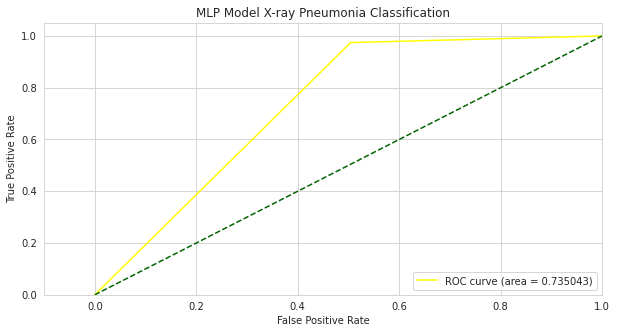

In [35]:
from sklearn.metrics import auc,roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [36]:
#save
plt.savefig('mlp_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [37]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              'AUC': []})

In [38]:
summary_table.loc[0] = ['Multilayer Perceptron Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.79,0.84,0.74,0.75,0.74


The MLP model performance is not great. For future work, we can tune parameters such as learning rate, batch size, try another optimizer, number of layers, number of neurons per layer, and the type of activation functions for each layer.

# Convolutional Neural Network Model (CNN)

In terms of DL, convolutional neural network (CNN) is the leading DL tool that is used to analyze visual images. In healthcare, CNN is a powerful tool due to its ability to extract features and learn to distinguish between different classes such as positive and negative, infected and healthy, or in this case, Pneumonia and Normal.

I add callbacks to monitor a specific parameter of the model, in this case, val_acc. Since I use a validation set during training, I set save_best_only = True in ModelCheckpoint to specify that the model will only be saved when its performance on the validation set is best.

I also set patience = 10 for EarlyStopping, meaning that the model will stop training if it doesn't see any improvement in val_acc in 10 epochs.

In [39]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
                 ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'val_loss', save_best_only = True)]

A CNN architecture is composed of convolutional layer with ReLU, pooling layer, fully connected layer, and loss layer.
* Start by initializing a Sequential model.
* Of course a CNN model needs to have convolutional layers, which is the core block of a CNN model. Convolutional layers apply a filter to input and create a feature map that summarizes the presence of detected features in the input. As observed in the above figure, the input image gets smaller and smaller as it progresses through the network but it also gets deeper and deeper with feature map. I add one Conv2D layer with a filter/kernel size of 3 x 3, adding ReLU activation function to set negative values to zero, and specify input_shape = (150, 150, 3).
* Pooling layer is sandwiched between two successive convolutional layers to reduce the spatial size of the convoluted feature/ parameters in the network. MaxPooling is the most common pooling methods to reduce image size by pooling the most important feature. Here I use MaxPool2D with a pool size of 2, meaning it divides each spatial dimension by a factor of 2.
* I repeat the above one more time
* Afterward, a Flatten layer is added to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). The flatten data that comes out of the convolutions and is then fed to the fully connected layers, which consist of two hidden Dense layers and an output hidden Dense layer with one neuron using activation = 'sigmoid'.

In [40]:
from keras.layers import Dropout, Flatten
from keras import regularizers

#initialize
cnn_model = models.Sequential()

#define model architecture
cnn_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(128, activation = 'relu'))

#one layer with sigmoid activation 
cnn_model.add(Dense(1, activation = 'sigmoid'))

In [41]:
#compile
cnn_model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [42]:
#get summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

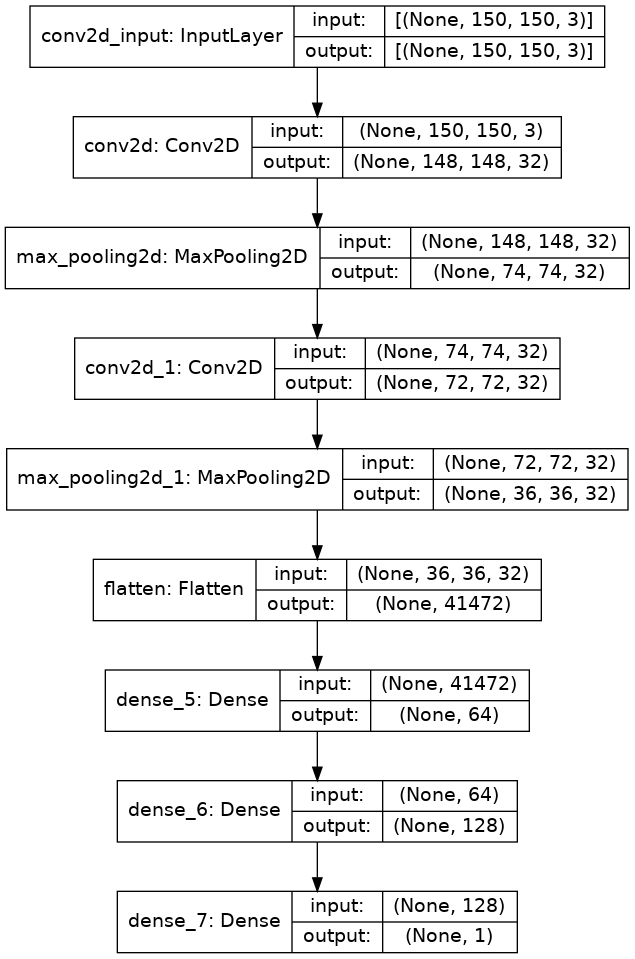

In [43]:
#plot
plot_model(cnn_model, to_file = 'cnn_model_plot.png', show_shapes = True, show_layer_names = True)

During fitting, I specify that my validation_data = test_generator, which uses the test set to validate training. Since there is 624 images in the test set, validation step = 624 // 32, where 32 is the batch_size.

In [44]:
start = datetime.datetime.now()

#fit
cnn_history = cnn_model.fit(train_generator,
                            steps_per_epoch = 5216 // 32,
                            epochs = 30,
                            validation_data = test_generator,
                            validation_steps = 624 // 32,
                            callbacks = early_stopping)

Epoch 1/30
163/163 [==============================] - 136s 827ms/step - loss: 0.5711 - acc: 0.7551 - val_loss: 0.6687 - val_acc: 0.6201
Epoch 2/30
163/163 [==============================] - 135s 824ms/step - loss: 0.4432 - acc: 0.7841 - val_loss: 0.4478 - val_acc: 0.7944
Epoch 3/30
163/163 [==============================] - 129s 789ms/step - loss: 0.3512 - acc: 0.8424 - val_loss: 0.3844 - val_acc: 0.8174
Epoch 4/30
163/163 [==============================] - 129s 789ms/step - loss: 0.3010 - acc: 0.8672 - val_loss: 0.3522 - val_acc: 0.8355
Epoch 5/30
163/163 [==============================] - 147s 899ms/step - loss: 0.2704 - acc: 0.8843 - val_loss: 0.3467 - val_acc: 0.8470
Epoch 6/30
163/163 [==============================] - 131s 805ms/step - loss: 0.2687 - acc: 0.8793 - val_loss: 0.3429 - val_acc: 0.8536
Epoch 7/30
163/163 [==============================] - 131s 801ms/step - loss: 0.2482 - acc: 0.9013 - val_loss: 0.3384 - val_acc: 0.8569
Epoch 8/30
163/163 [============================

In [45]:
#time
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 1:02:58.787390


In [46]:
#save model
cnn_model.save('cnn_model.h5')

### Model Evaluation

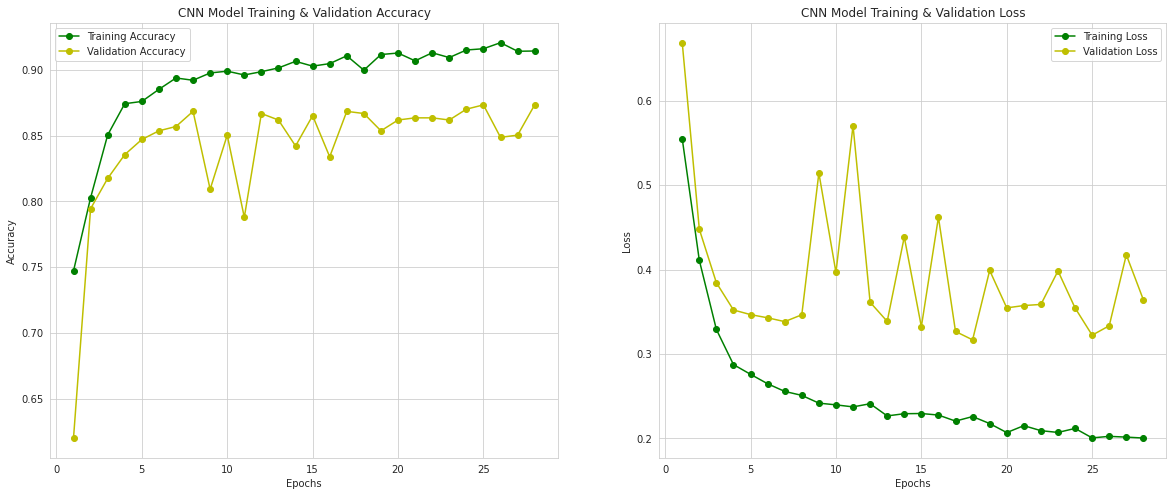

In [47]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

cnn_train_acc = cnn_history.history['acc']
cnn_train_loss = cnn_history.history['loss']
cnn_val_acc = cnn_history.history['val_acc']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_train_acc) + 1)

ax[0].plot(epochs , cnn_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , cnn_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('CNN Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , cnn_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , cnn_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('CNN Model Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [48]:
#save
plt.savefig('cnn_model.png')

<Figure size 432x288 with 0 Axes>

In [49]:
#evaluate
print('Train loss & accuracy:' , cnn_model.evaluate(train_generator))
print('\n')
print('Test loss & accuracy:' , cnn_model.evaluate(test_generator))

163/163 [==============================] - 99s 607ms/step - loss: 0.1860 - acc: 0.9273
Train loss & accuracy: [0.18603405356407166, 0.9273389577865601]


20/20 [==============================] - 8s 354ms/step - loss: 0.3565 - acc: 0.8766
Test loss & accuracy: [0.3564613461494446, 0.8766025900840759]


Train and test accuracy are similar. The model is not overfit. We can see that the Train curve and Validation curve are closely resemble each other. As training goes on, both Accuracy curves increases while Loss curve decreases, which indicates a well-trained, well-generalized model.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[172  62]
 [ 15 375]]


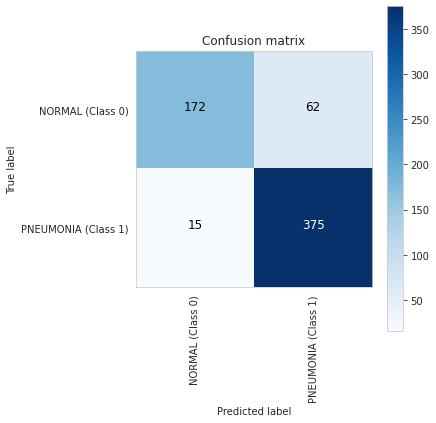

In [50]:
#define target for testing
y_test = test_generator.classes

#make prediction
yhat_test = cnn_model.predict_classes(test_generator)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot confusion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [51]:
#save
plt.savefig('cnn_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [52]:
#get classification report
print('Model: CNN', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: CNN 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.74      0.82       234
PNEUMONIA (Class 1)       0.86      0.96      0.91       390

           accuracy                           0.88       624
          macro avg       0.89      0.85      0.86       624
       weighted avg       0.88      0.88      0.87       624



CNN model is a big improvement on the previous MLP model. 

Both of TP and TN are higher than FP and FN. FP is also higher than FN.

This model perform well with both class Pneumonia and class Normal, with class Pneumonia having a higher F1-score.

AUC: 0.8482905982905984


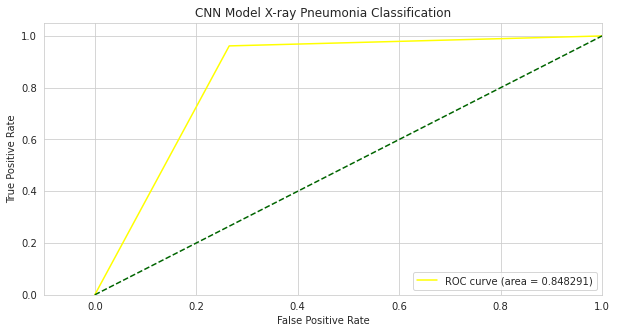

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [54]:
#save
plt.savefig('cnn_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [55]:
#update summary table
summary_table.loc[1] = ['Convolutional Neural Network Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.79,0.84,0.74,0.75,0.74
1,Convolutional Neural Network Model,0.88,0.89,0.85,0.86,0.85


# Pretrained CNN Model

Since the dataset used is small, one method of addressing this lack of data in a given domain is to leverage data from a similar domain, a technique known as Transfer Learning (TL) (Kermany et al., 2018). In short, TL means using what is learned from one task and applying that to another task without learning from scratch. 

I adapted an VGG16 architecture pretrained on the ImageNet dataset. VGG16 model is composed of convolutions layers, max pooling layers, and fully connected layers. The total is 16 layers, including 13 convolutional layers and 3 fully connected layers, with 5 blocks and each block with a max pooling layer.

Adapting a pretrained model will undoubtedly produce better results than a fresh CNN due to the limited size of training data. We will import a pretrained model VGG16 to use as the convolutional base. By doing this, we transform the dataset into a rich feature space and add a few fully connected layers on top of the pretrained layers to build a classification model.

First, I initialize VGG16 model and use weights = 'imagenet', which is a large visual database designed for use in visual object recognition software research. This database has over 15 million labeled high-resolution images belonging to roughly 22,000 categories.

In [56]:
#initialize base CNN
from keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (150, 150, 3),
                 classes = 2,
                 classifier_activation = 'sigmoid')

58892288/58889256 [==============================] - 1s 0us/step


The pre-trained convolutional layers need to be frozen by setting .trainable = False. This will prevent the weights, which are initially calculated and stored in order to reduce redundant processes and speed up training,  in the pre-trained layers from being updated while training and later used as fixed feature extractors.

In [57]:
#leave the pretrained model frozen to prevent the weights in a given layer from being updated during training.
cnn_base.trainable = False

* Sequential model is initialized.
* VGG16 is added as cnn_base.
* After the images are trained through the cnn_base, they are retrained through fully connected layers to classify the specific categories of Normal and Pneumonia. Each Dense layer are followed with Dropout layers whose function is to reduce overfitting by reducing the number of neurons.
* The final fully connected layer is the classification layer with actitvation = 'sigmoid'.

In [58]:
#define model architecture
pretrainedCNN_model = models.Sequential()

pretrainedCNN_model.add(cnn_base)

#fully connected layer
pretrainedCNN_model.add(layers.Flatten())

pretrainedCNN_model.add(Dense(640, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))
pretrainedCNN_model.add(Dense(128, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))

#output layer
pretrainedCNN_model.add(layers.Dense(1, activation = 'sigmoid'))

In [59]:
#check whether a layer is trainable (or alter its setting) 
for layer in pretrainedCNN_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_8 True
dropout True
dense_9 True
dropout_1 True
dense_10 True


In [60]:
#compile
pretrainedCNN_model.compile(loss = 'binary_crossentropy',
                            optimizer = keras.optimizers.Adam(0.0001),
                            metrics = ['acc'])

In [61]:
#get summary
pretrainedCNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 640)               5243520   
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

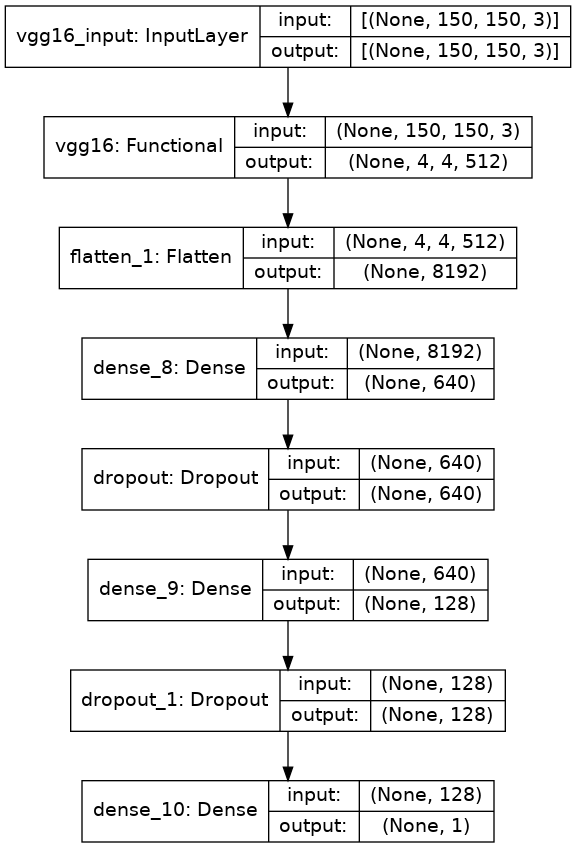

In [62]:
#plot
plot_model(pretrainedCNN_model, to_file = 'pretrainedCNN_model_plot.png', show_shapes = True, show_layer_names = True)

In [63]:
start = datetime.datetime.now()

#fit
pretrainedCNN_history = pretrainedCNN_model.fit(train_generator,
                                                steps_per_epoch = 5216 // 32,
                                                epochs = 30,
                                                validation_data = test_generator,
                                                validation_steps = 624 // 32,
                                                callbacks = early_stopping)

Epoch 1/30
163/163 [==============================] - 679s 4s/step - loss: 0.4907 - acc: 0.7773 - val_loss: 0.3325 - val_acc: 0.8618
Epoch 2/30
163/163 [==============================] - 668s 4s/step - loss: 0.2596 - acc: 0.8900 - val_loss: 0.3363 - val_acc: 0.8750
Epoch 3/30
163/163 [==============================] - 652s 4s/step - loss: 0.2326 - acc: 0.9005 - val_loss: 0.3482 - val_acc: 0.8799
Epoch 4/30
163/163 [==============================] - 646s 4s/step - loss: 0.2244 - acc: 0.9103 - val_loss: 0.2634 - val_acc: 0.8964
Epoch 5/30
163/163 [==============================] - 658s 4s/step - loss: 0.2117 - acc: 0.9131 - val_loss: 0.2731 - val_acc: 0.9013
Epoch 6/30
163/163 [==============================] - 662s 4s/step - loss: 0.2108 - acc: 0.9181 - val_loss: 0.2682 - val_acc: 0.9062
Epoch 7/30
163/163 [==============================] - 650s 4s/step - loss: 0.1922 - acc: 0.9212 - val_loss: 0.2501 - val_acc: 0.9013
Epoch 8/30
163/163 [==============================] - 647s 4s/step - 

In [64]:
#time
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 5:16:32.074610


In [65]:
#save model
pretrainedCNN_model.save('pretrainedCNN_model.h5')

### Model Evaluation

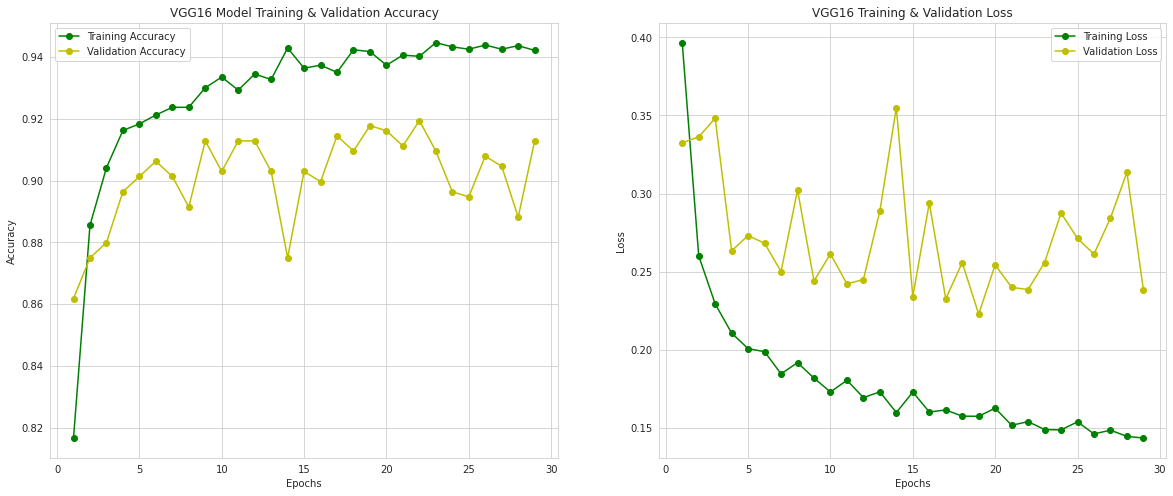

In [66]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

pretrainedCNN_train_acc = pretrainedCNN_history.history['acc']
pretrainedCNN_train_loss = pretrainedCNN_history.history['loss']
pretrainedCNN_val_acc = pretrainedCNN_history.history['val_acc']
pretrainedCNN_val_loss = pretrainedCNN_history.history['val_loss']

epochs = range(1, len(pretrainedCNN_train_acc) + 1)

ax[0].plot(epochs , pretrainedCNN_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , pretrainedCNN_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('VGG16 Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , pretrainedCNN_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , pretrainedCNN_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('VGG16 Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [67]:
#save
plt.savefig('VGG16_cnn_model.png')

<Figure size 432x288 with 0 Axes>

In [68]:
print('Train loss & accuracy:' , pretrainedCNN_model.evaluate(train_generator))
print('\n')
print('Test loss & accuracy:' , pretrainedCNN_model.evaluate(test_generator))

163/163 [==============================] - 579s 4s/step - loss: 0.1369 - acc: 0.9465
Train loss & accuracy: [0.13685134053230286, 0.9465107321739197]


20/20 [==============================] - 67s 3s/step - loss: 0.2330 - acc: 0.9151
Test loss & accuracy: [0.23303863406181335, 0.9150640964508057]


Train and test accuracy are similar. The model is not overfit. Train curve and Validation curve are following each other closely. Accuracy improves overtime and Loss decreases overtime.

In [69]:
#make prediction
yhat_test = pretrainedCNN_model.predict_classes(test_generator)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[200  34]
 [ 19 371]]


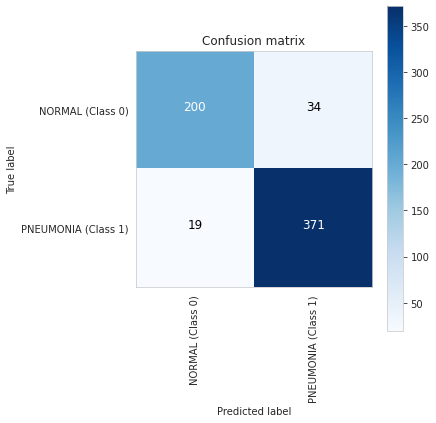

In [70]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [71]:
#save
plt.savefig('VGG16_cnn_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [72]:
#get classification report
print('Model: VGG16 CNN Model', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: VGG16 CNN Model 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.91      0.85      0.88       234
PNEUMONIA (Class 1)       0.92      0.95      0.93       390

           accuracy                           0.92       624
          macro avg       0.91      0.90      0.91       624
       weighted avg       0.91      0.92      0.91       624



AUC: 0.9029914529914529


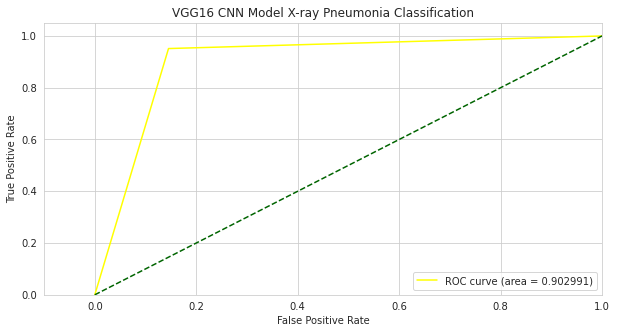

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [74]:
#save
plt.savefig('VGG16_cnn_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [75]:
#update summary table
summary_table.loc[2] = ['Transfer Learning: VGG16 CNN Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.79,0.84,0.74,0.75,0.74
1,Convolutional Neural Network Model,0.88,0.89,0.85,0.86,0.85
2,Transfer Learning: VGG16 CNN Model,0.92,0.91,0.90,0.91,0.90


In [76]:
#save
summary_table.to_csv('summary_table.csv')

# Future Work
1. Build a multi-class classification deep learning model to distinguish between Normal, Viral Pneumonia, and Bacterial Pneumonia

2. Combine CNN models with other classifiers such as Support Vector Machine (SVM) 

3. Tune parameters such as learning rate, batch size, try another optimizer, number of layers, different types of layer, number of neurons per layer, and the type of activation functions for each layer. GridSearchCV or RandomizedSearchSV can be used to achieve this.

# Blog

https://baotramduong.medium.com/x-ray-pneumonia-classification-with-deep-learning-6a81861150a1

# Github

https://github.com/baotramduong/Portfolio_Project_Deep_Learning_Image_Classification

# Reference

Geron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2nd ed.). O'Reilly.

Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C., Liang, H., Baxter, S. L., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M. K., Pei, J., Ting, M., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., Shi, A., … Zhang, K. (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, 172(5), 1122–1131.e9. https://doi.org/10.1016/j.cell.2018.02.010

Unicef. (2021, April 07). Pneumonia in children statistics. Retrieved April 13, 2021, from https://data.unicef.org/topic/child-health/pneumonia/#:~:text=A%20child%20dies%20of%20pneumonia,of%20these%20deaths%20are%20preventable.